**PHÂN LOẠI ẢNH BẰNG MOBILENETV2 - TRANSFER LEARNING**

- Sử dụng mô hình MobileNetV2 đã được huấn luyện trên ImageNet (>14 triệu ảnh)
- Áp dụng Transfer Learning: giữ lại kiến thức đã học, chỉ fine-tune phần đầu ra
- Phân loại ảnh vào các danh mục cụ thể của bạn

CẤU TRÚC MÔ HÌNH:
-----------------
1. BASE MODEL (MobileNetV2): Trích xuất đặc trưng từ ảnh
2. GLOBAL POOLING: Giảm chiều dữ liệu
3. DENSE LAYERS: Học các đặc trưng cụ thể cho bài toán của bạn
4. SOFTMAX: Dự đoán xác suất cho từng class

QUY TRÌNH TRAINING:
-------------------
Phase 1: Freeze base model → Train only top layers (Fast learning)
Phase 2: Unfreeze some layers → Fine-tune (Slow, careful learning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from datetime import datetime
import json

warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Đường dẫn dữ liệu
DATA_DIR = '/content/drive/MyDrive/DAHM/train'
VAL_DIR = '/content/drive/MyDrive/DAHM/val'
SAVE_DIR = '/content/drive/MyDrive/DAHM/models'
os.makedirs(SAVE_DIR, exist_ok=True)


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_PHASE1 = 15  # Training với base frozen
EPOCHS_PHASE2 = 10  # Fine-tuning
LEARNING_RATE_PHASE1 = 0.001
LEARNING_RATE_PHASE2 = 0.0001

print("-" * 80)
print(f"Image Size           : {IMG_SIZE}")
print(f"Batch Size           : {BATCH_SIZE}")
print(f"Phase 1 Epochs       : {EPOCHS_PHASE1} (frozen base)")
print(f"Phase 2 Epochs       : {EPOCHS_PHASE2} (fine-tuning)")
print(f"Phase 1 LR           : {LEARNING_RATE_PHASE1}")
print(f"Phase 2 LR           : {LEARNING_RATE_PHASE2}")


--------------------------------------------------------------------------------
Image Size           : (224, 224)
Batch Size           : 32
Phase 1 Epochs       : 15 (frozen base)
Phase 2 Epochs       : 10 (fine-tuning)
Phase 1 LR           : 0.001
Phase 2 LR           : 0.0001


**DATA AUGMENTATION**

1. rotation_range=30: Xoay ảnh ngẫu nhiên trong khoảng [-30°, +30°]
   → Mô hình học được object ở các góc độ khác nhau

2. width_shift_range=0.3: Dịch ngang 30% chiều rộng
   height_shift_range=0.3: Dịch dọc 30% chiều cao
   → Object không phải lúc nào cũng ở giữa ảnh

3. zoom_range=0.3: Phóng to/thu nhỏ 30%
   → Học được object ở các kích thước khác nhau

4. horizontal_flip=True: Lật ngang ảnh
   → Tăng gấp đôi dữ liệu, phù hợp với hầu hết bài toán
    Lưu ý: KHÔNG dùng vertical_flip cho ảnh có hướng (chữ, người, xe...)

5. shear_range=0.2: Biến dạng nghiêng (shearing transformation)
   → Mô phỏng các góc nhìn xiên, perspective khác nhau

6. brightness_range=[0.7, 1.3]: Thay đổi độ sáng ±30%
   → Học được object trong điều kiện ánh sáng khác nhau

7. channel_shift_range=20: Dịch chuyển giá trị màu RGB
   → Mô phỏng các điều kiện màu sắc, white balance khác nhau

8. fill_mode='nearest': Điền pixel khi có khoảng trống sau transform
   → Các option khác: 'constant', 'reflect', 'wrap'

9. preprocessing_function: Chuẩn hóa theo chuẩn MobileNetV2
   → Scale pixel từ [0, 255] về [-1, 1]

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Chuẩn hóa giống ImageNet [-1,1]

    # Geometric Transformations
    rotation_range=30,              # Xoay ±30°
    width_shift_range=0.3,          # Dịch ngang 30%
    height_shift_range=0.3,         # Dịch dọc 30%
    zoom_range=0.3,                 # Zoom 70%-130%
    shear_range=0.2,                # Shear ±0.2
    horizontal_flip=True,           # Lật ngang

    # Color Augmentation
    brightness_range=[0.7, 1.3],    # Độ sáng 70%-130%
    channel_shift_range=20.0,       # Dịch màu RGB ±20

    # Fill mode
    fill_mode='nearest',            # Điền pixel: nearest/constant/reflect/wrap

    # Data format
    data_format='channels_last'     # (height, width, channels)
)

# Validation chỉ cần preprocessing, KHÔNG augmentation
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
NUM_CLASSES = len(class_names)

print(f"\n{'THÔNG TIN DỮ LIỆU':^80}")
print(f"Số lượng classes     : {NUM_CLASSES}")
print(f"Tên các classes      : {class_names}")
print(f"Tổng ảnh train       : {train_gen.samples}")
print(f"Tổng ảnh validation  : {val_gen.samples}")
print(f"Steps per epoch      : {train_gen.samples // BATCH_SIZE}")
print(f"Validation steps     : {val_gen.samples // BATCH_SIZE}")

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.

                               THÔNG TIN DỮ LIỆU                                
Số lượng classes     : 3
Tên các classes      : ['angular_leaf_spot', 'bean_rust', 'healthy']
Tổng ảnh train       : 1034
Tổng ảnh validation  : 133
Steps per epoch      : 32
Validation steps     : 4


**HIỂN THỊ MẪU ẢNH SAU AUGMENTATION**


 Hiển thị mẫu ảnh sau Data Augmentation...


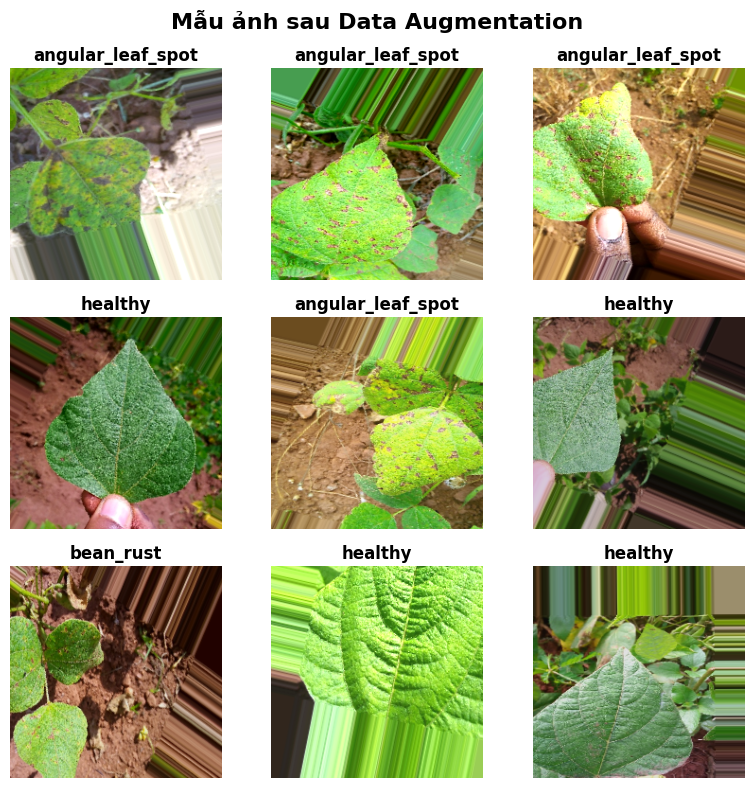

In [ ]:
def visualize_augmentation(generator, num_samples=9):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        img, label = next(generator)
        # Denormalize để hiển thị (MobileNetV2 preprocessing: [-1, 1] → [0, 1])
        img_display = (img[0] + 1) / 2.0
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        class_idx = np.argmax(label[0])
        axes[i].set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
        axes[i].axis('off')

    plt.suptitle('Mẫu ảnh sau Data Augmentation', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n Hiển thị mẫu ảnh sau Data Augmentation...")
visualize_augmentation(train_gen)

CLASS WEIGHTS

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weight_dict = dict(enumerate(class_weights))

print(f"\n{'CLASS WEIGHTS (Để cân bằng dữ liệu)':^80}")
for class_name, weight in zip(class_names, class_weights):
    print(f"{class_name:20s}: {weight:.4f}")




                      CLASS WEIGHTS (Để cân bằng dữ liệu)                       
angular_leaf_spot   : 0.9990
bean_rust           : 0.9904
healthy             : 1.0108


KIẾN TRÚC MOBILENETV2

1. BASE MODEL (MobileNetV2 pre-trained):
   - Đã học từ ImageNet (1000 classes, 14M+ ảnh)
   - Trích xuất 1280 feature maps
   - Sử dụng Depthwise Separable Convolutions → nhẹ, nhanh
   
2. GLOBAL AVERAGE POOLING 2D:
   - Input: (None, 7, 7, 1280)
   - Output: (None, 1280)
   - Lấy trung bình của mỗi feature map → giảm overfitting
   
3. BATCH NORMALIZATION:
   - Chuẩn hóa output của GAP → training ổn định hơn
   
4. DENSE LAYER 1 (512 units):
   - Học các đặc trưng phức tạp, cụ thể cho bài toán
   - ReLU activation
   - L2 regularization (0.01) → giảm overfitting
   
5. DROPOUT (0.5):
   - Tắt ngẫu nhiên 50% neurons mỗi batch
   - Ngăn co-adaptation → tổng quát hóa tốt hơn
   
6. DENSE LAYER 2 (256 units):
   - Học các đặc trưng tinh tế hơn
   - ReLU + L2 + Dropout tương tự
   
7. OUTPUT LAYER (NUM_CLASSES units):
   - Softmax activation
   - Output: Xác suất cho từng class (tổng = 1)

In [ ]:
print(f"\n{'XÂY DỰNG MÔ HÌNH MOBILENETV2'}")
print("=" * 80)

# Load MobileNetV2 với weights từ ImageNet
base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,  # Bỏ phần classification gốc
    input_shape=(224, 224, 3),
    alpha=1.0  # Width multiplier (1.0 = full size)
)

# Đóng băng base model trong Phase 1
base_model.trainable = False

# Xây dựng model hoàn chỉnh
model = models.Sequential([
    base_model,

    layers.GlobalAveragePooling2D(name='gap'),
    layers.BatchNormalization(name='bn_1'),

    layers.Dense(512, activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.01),
                 name='dense_1'),
    layers.Dropout(0.5, name='dropout_1'),

    layers.Dense(256, activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.01),
                 name='dense_2'),
    layers.Dropout(0.3, name='dropout_2'),

    layers.Dense(NUM_CLASSES, activation='softmax', name='output')
], name='MobileNetV2_Custom')

print("\n KIẾN TRÚC MÔ HÌNH:")
model.summary()

# Phân tích tham số
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\n{'THỐNG KÊ THAM SỐ':^80}")

print(f"Tổng tham số         : {total_params:,}")
print(f"Trainable            : {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
print(f"Non-trainable        : {non_trainable_params:,} ({non_trainable_params/total_params*100:.1f}%)")



XÂY DỰNG MÔ HÌNH MOBILENETV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 KIẾN TRÚC MÔ HÌNH:


Model: "MobileNetV2_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 1280)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,075 (11.64 MB)

 Trainable params: 790,531 (3.02 MB)

 Non-trainable params: 2,260,544 (8.62 MB)


                                THỐNG KÊ THAM SỐ                                
Tổng tham số         : 3,051,075
Trainable            : 790,531 (25.9%)
Non-trainable        : 2,260,544 (74.1%)


In [ ]:
print(f"\n{'PHASE 1: TRAINING VỚI FROZEN BASE MODEL':^80}")
print("=" * 80)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_PHASE1),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

callbacks_phase1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(
        f'{SAVE_DIR}/best_model_phase1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print(" Bắt đầu Phase 1 Training...")
print(f"   Learning Rate: {LEARNING_RATE_PHASE1}")
print(f"   Epochs: {EPOCHS_PHASE1}")
print(f"   Base Model: FROZEN")

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks_phase1,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n HOÀN THÀNH PHASE 1!")

# Đánh giá Phase 1
val_gen.reset()
results_phase1 = model.evaluate(val_gen, verbose=0)
print(f"\n{'KẾT QUẢ PHASE 1':^80}")
print(f"Val Loss             : {results_phase1[0]:.4f}")
print(f"Val Accuracy         : {results_phase1[1]:.4f} ({results_phase1[1]*100:.2f}%)")
print(f"Top-3 Accuracy       : {results_phase1[2]:.4f} ({results_phase1[2]*100:.2f}%)")
print(f"Precision            : {results_phase1[3]:.4f}")
print(f"Recall               : {results_phase1[4]:.4f}")


                    PHASE 1: TRAINING VỚI FROZEN BASE MODEL                     
 Bắt đầu Phase 1 Training...
   Learning Rate: 0.001
   Epochs: 15
   Base Model: FROZEN
Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6126 - loss: 11.3552 - precision: 0.6158 - recall: 0.5726 - top_3_accuracy: 1.0000 
Epoch 1: val_accuracy improved from -inf to 0.78947, saving model to /content/drive/MyDrive/DAHM/models/best_model_phase1.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 303s 9s/step - accuracy: 0.6144 - loss: 11.3394 - precision: 0.6178 - recall: 0.5750 - top_3_accuracy: 1.0000 - val_accuracy: 0.7895 - val_loss: 9.6043 - val_precision: 0.8305 - val_recall: 0.7368 - val_top_3_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.7830 - loss: 9.2580 - precision: 0.7929 - recall: 0.7702 - top_3_accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.78947 to 0.86466, saving model to /content/drive/MyDrive/DAHM/models/best_model_phase1.kera

In [ ]:
print(f"\n{'PHASE 2: FINE-TUNING':^80}")
print("=" * 80)

# Unfreeze một số layers cuối của base model
base_model.trainable = True
fine_tune_at = 100  # Unfreeze từ layer 100 trở đi

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Đếm lại trainable params
trainable_params_phase2 = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"Trainable params Phase 2: {trainable_params_phase2:,} ({trainable_params_phase2/total_params*100:.1f}%)")

# Compile lại với learning rate thấp
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_PHASE2),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-8,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(
        f'{SAVE_DIR}/best_model_final.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print(" Bắt đầu Phase 2 Fine-tuning...")
print(f"   Learning Rate: {LEARNING_RATE_PHASE2}")
print(f"   Epochs: {EPOCHS_PHASE2}")
print(f"   Unfrozen layers: {len([l for l in base_model.layers if l.trainable])}")

history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks_phase2,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n HOÀN THÀNH PHASE 2!")

# ==================== BƯỚC 10: ĐÁNH GIÁ CUỐI CÙNG ====================
print(f"\n{'ĐÁNH GIÁ CUỐI CÙNG':^80}")


val_gen.reset()
results_final = model.evaluate(val_gen, verbose=1)

print(f"\n{'KẾT QUẢ CUỐI CÙNG':^80}")

print(f"Val Loss             : {results_final[0]:.4f}")
print(f"Val Accuracy         : {results_final[1]:.4f} ({results_final[1]*100:.2f}%)")
print(f"Top-3 Accuracy       : {results_final[2]:.4f} ({results_final[2]*100:.2f}%)")
print(f"Precision            : {results_final[3]:.4f}")
print(f"Recall               : {results_final[4]:.4f}")
print(f"F1-Score             : {2*(results_final[3]*results_final[4])/(results_final[3]+results_final[4]):.4f}")




                              PHASE 2: FINE-TUNING                              
Trainable params Phase 2: 2,651,971 (86.9%)
 Bắt đầu Phase 2 Fine-tuning...
   Learning Rate: 0.0001
   Epochs: 10
   Unfrozen layers: 54
Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.8037 - loss: 1.1838 - precision: 0.8305 - recall: 0.7762 - top_3_accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.92481, saving model to /content/drive/MyDrive/DAHM/models/best_model_final.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8044 - loss: 1.1813 - precision: 0.8310 - recall: 0.7772 - top_3_accuracy: 1.0000 - val_accuracy: 0.9248 - val_loss: 0.8601 - val_precision: 0.9318 - val_recall: 0.9248 - val_top_3_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.8878 - loss: 0.9303 - precision: 0.9065 - recall: 0.8799 - top_3_accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.92481 to 0.96241, saving model to /content/drive/MyDrive/DAHM/models/best_model_final.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 732ms/step - accuracy: 0.8879 - loss: 0.9305 - precision: 0.9064 - recall: 0.8800 - top_3_accuracy: 1.0000 - val_accuracy: 0.9624 - val_loss: 0.8122 - val_precision: 0.9621 - val_recall: 0.9549 - val_top_3_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9303 - loss: 0.8635 - precision: 0.9352 - recall: 0.9216 - top_3_accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.96241
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 658ms/step - accuracy: 0.9303 - loss: 0.8624 - precision: 0.9352 - recall: 0.9217 - top_3_accuracy: 1.0000 - val_accuracy: 0.8647 - val_loss: 0.8879 - val_precision: 0.8647 - val_recall: 0.8647 - val_top_3_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9242 - loss: 0.8205 - precision: 0.9297 - recall: 0.9172 - top_3_accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.96241
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 668ms/s

CONFUSION MATRIX:
-----------------
- Hàng: True label
- Cột: Predicted label
- Đường chéo: Dự đoán đúng
- Ngoài đường chéo: Dự đoán sai

Phân tích:
- Precision = TP / (TP + FP): Độ chính xác khi dự đoán class này
- Recall = TP / (TP + FN): Khả năng tìm ra đúng class này
- F1-Score = 2 * (Precision * Recall) / (Precision + Recall)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


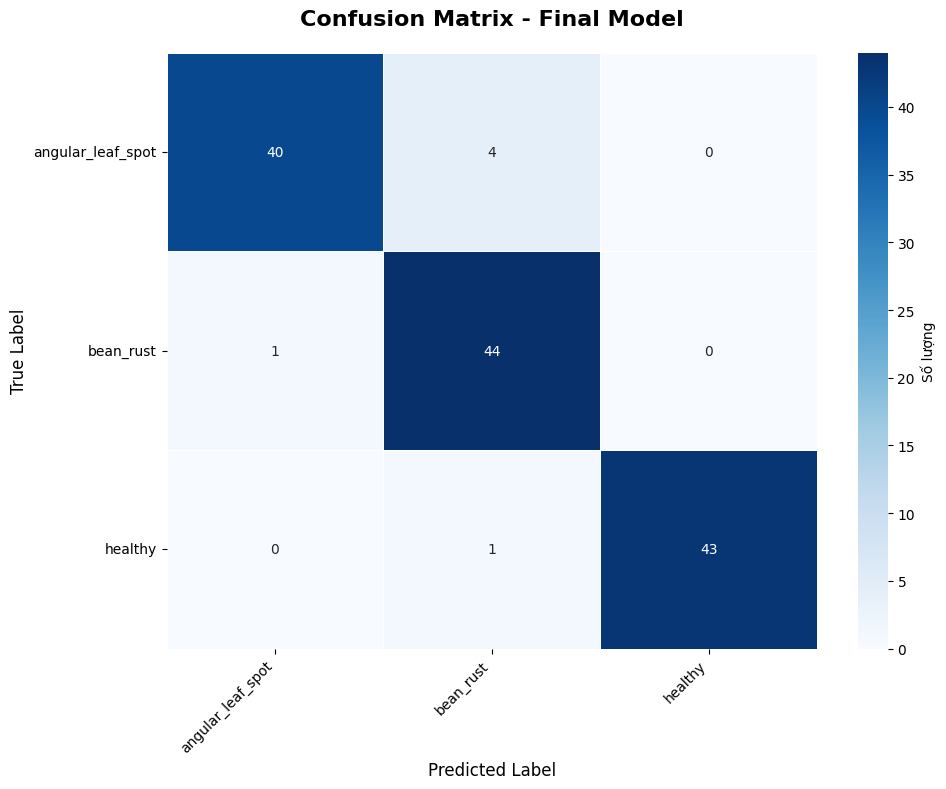


                             CLASSIFICATION REPORT                              
                   precision    recall  f1-score   support

angular_leaf_spot     0.9756    0.9091    0.9412        44
        bean_rust     0.8980    0.9778    0.9362        45
          healthy     1.0000    0.9773    0.9885        44

         accuracy                         0.9549       133
        macro avg     0.9579    0.9547    0.9553       133
     weighted avg     0.9574    0.9549    0.9551       133



In [ ]:
val_gen.reset()
y_pred = model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Số lượng'}, linewidths=0.5)
plt.title('Confusion Matrix - Final Model', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/confusion_matrix.png', dpi=300)
plt.show()

# Classification Report
print(f"\n{'CLASSIFICATION REPORT':^80}")
report = classification_report(y_true, y_pred_classes, target_names=class_names, digits=4)
print(report)

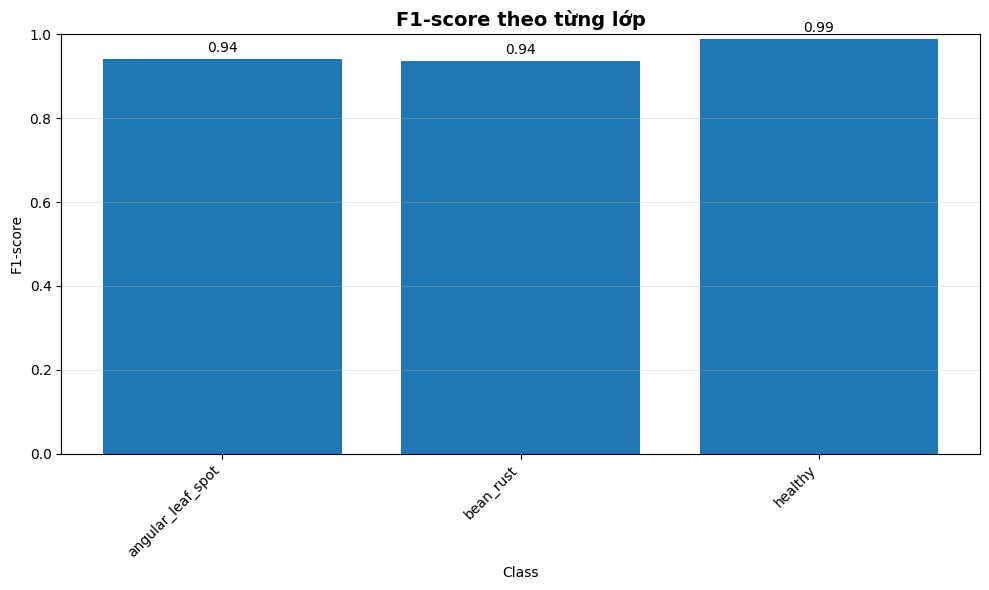

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Classification report dạng dict
report_dict = classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    output_dict=True
)

# Chuyển sang DataFrame
df_report = pd.DataFrame(report_dict).transpose()

# Lấy F1-score của từng class
f1_scores = df_report.loc[class_names, 'f1-score']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, f1_scores)

plt.title('F1-score theo từng lớp', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.ylim(0, 1)

# Ghi giá trị lên cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01,
             f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/f1_score_per_class.png', dpi=300)
plt.show()


1. ACCURACY:
   - Train tăng, Val tăng theo → Tốt
   - Train tăng, Val plateau/giảm → Overfitting

2. LOSS:
   - Train giảm, Val giảm theo → Tốt
   - Train giảm, Val tăng → Overfitting

3. OVERFITTING GAP:
   - Gap nhỏ (<5%) → Tốt
   - Gap lớn (>10%) → Overfitting, cần thêm regularization

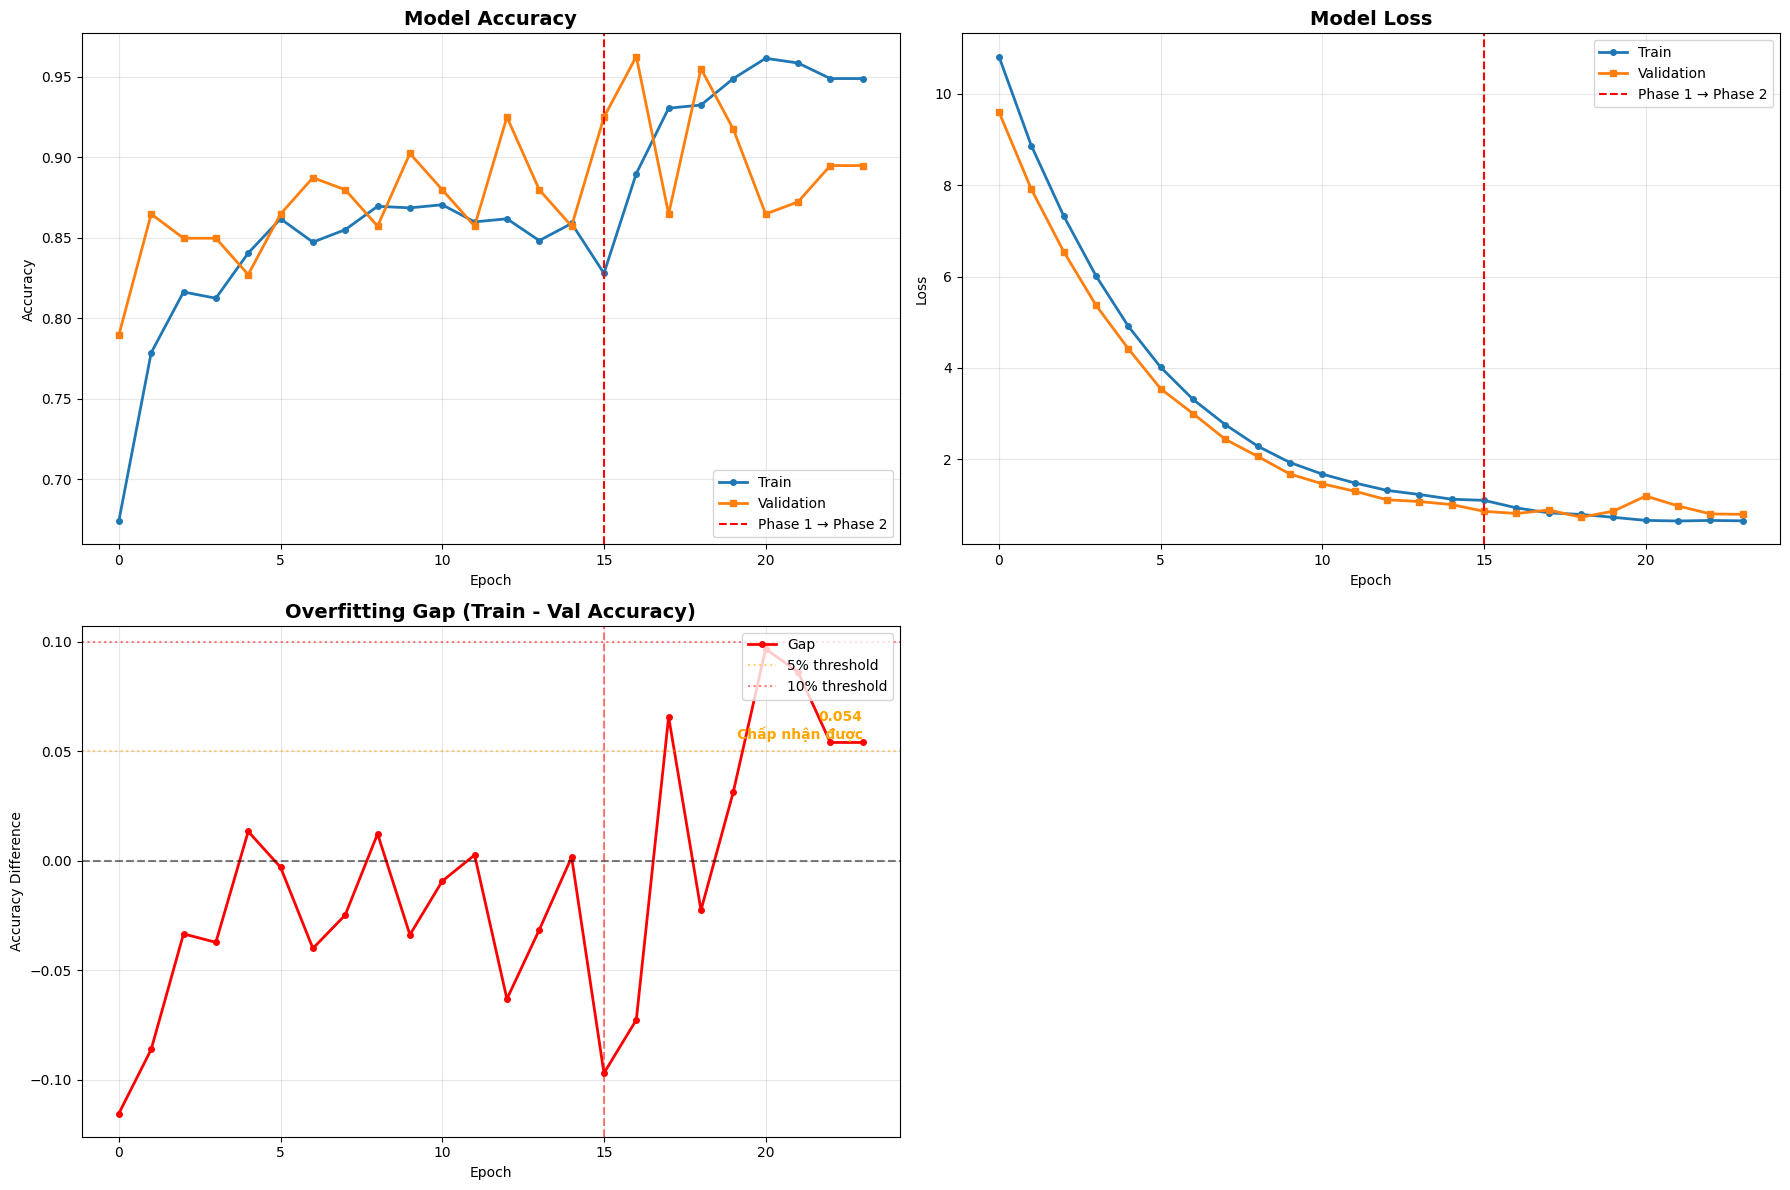


 PHÂN TÍCH TRAINING CURVES:
Best Train Accuracy      : 0.9613
Best Val Accuracy        : 0.9624
Final Train Accuracy     : 0.9487
Final Val Accuracy       : 0.8947
Final Overfitting Gap    : 0.0540 (Chấp nhận được)
Min Val Loss             : 0.7301
Final Val Loss           : 0.7940


In [ ]:
combined_history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
}

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# ================= Accuracy =================
axes[0, 0].plot(combined_history['accuracy'], label='Train', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(combined_history['val_accuracy'], label='Validation', linewidth=2, marker='s', markersize=4)
axes[0, 0].axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--', label='Phase 1 → Phase 2')
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(True, alpha=0.3)

# ================= Loss =================
axes[0, 1].plot(combined_history['loss'], label='Train', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(combined_history['val_loss'], label='Validation', linewidth=2, marker='s', markersize=4)
axes[0, 1].axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', label='Phase 1 → Phase 2')
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True, alpha=0.3)

# ================= Overfitting Gap =================
epochs_range = range(len(combined_history['accuracy']))
train_val_gap = np.array(combined_history['accuracy']) - np.array(combined_history['val_accuracy'])

axes[1, 0].plot(epochs_range, train_val_gap, linewidth=2, marker='o', markersize=4, color='red', label='Gap')
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=0.05, color='orange', linestyle=':', alpha=0.5, label='5% threshold')
axes[1, 0].axhline(y=0.10, color='red', linestyle=':', alpha=0.5, label='10% threshold')
axes[1, 0].axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--', alpha=0.5)

axes[1, 0].set_title('Overfitting Gap (Train - Val Accuracy)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy Difference')
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(True, alpha=0.3)

# ================= Annotation =================
final_gap = train_val_gap[-1]
gap_color = 'green' if final_gap < 0.05 else ('orange' if final_gap < 0.10 else 'red')
gap_status = 'Tốt' if final_gap < 0.05 else ('Chấp nhận được' if final_gap < 0.10 else 'Overfitting')

axes[1, 0].text(len(train_val_gap) - 1, final_gap,
                f'{final_gap:.3f}\n{gap_status}',
                fontsize=10, color=gap_color, fontweight='bold',
                ha='right', va='bottom')

# Ô trống (để layout đẹp)
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n PHÂN TÍCH TRAINING CURVES:")
print(f"Best Train Accuracy      : {max(combined_history['accuracy']):.4f}")
print(f"Best Val Accuracy        : {max(combined_history['val_accuracy']):.4f}")
print(f"Final Train Accuracy     : {combined_history['accuracy'][-1]:.4f}")
print(f"Final Val Accuracy       : {combined_history['val_accuracy'][-1]:.4f}")
print(f"Final Overfitting Gap    : {final_gap:.4f} ({gap_status})")
print(f"Min Val Loss             : {min(combined_history['val_loss']):.4f}")
print(f"Final Val Loss           : {combined_history['val_loss'][-1]:.4f}")
